Investigate the glacier-scale and regional-scale trend in water area over time

In [109]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

In [110]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [111]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [117]:
# open the water data for each glacier, format into a single df

# choose if you want to use the QA or ACCA cloud products
product = 'acca'
product = 'qa'
product = 'otsu_include0'

c=0
all_series = []
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>10: continue
    
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    o3region = row['o3region']
    
    # if o1region!='15':continue
    # print progress
    # print(c, "of", len(rgi_gdf), rgi_id)
    if c%100==0: print(c, "of", len(rgi_gdf), rgi_id)

    # open glacier-specific cloud info as a pd.Series, append to list
    if product=='acca':
        path_open = os.path.join(folder_glaciers, rgi_id, 'annual_water_info_acca.csv')
    elif product=='qa':
        path_open = os.path.join(folder_glaciers, rgi_id, 'annual_water_info.csv')
    elif product=='otsu_include0':
        path_open = os.path.join(folder_glaciers, rgi_id, 'annual_water_info_otsu_include0.csv')
    else:
        print("ERROR")
    df_g = pd.read_csv(path_open, index_col=0, header=None).squeeze()
    df_g['o3_region'] = str(o3region)
    all_series.append(df_g)

# format into df
df_all = pd.DataFrame(all_series).reset_index(drop=True)


# format to numeric dtypes
all_cols = df_all.columns
for c in all_cols:
    if c in ['rgi_id', 'o1_region', 'o2_region', 'o3_region']: continue
    df_all[c] = df_all[c].astype(float)

# add extra columns on for each glacier (dc area, etc...)
df_all = df_all.merge(dc_gdf[['rgi_id','area_dc']], on='rgi_id')

# merge with glacier area
print("All done!")

100 of 769 RGI2000-v7.0-G-14-06944
200 of 769 RGI2000-v7.0-G-13-71307
300 of 769 RGI2000-v7.0-G-14-15108
400 of 769 RGI2000-v7.0-G-14-32564
500 of 769 RGI2000-v7.0-G-15-01330
600 of 769 RGI2000-v7.0-G-15-05352
700 of 769 RGI2000-v7.0-G-15-08609
All done!


In [118]:
df_big = df_all[df_all['area_dc']>5]
len(df_big)

114

In [17]:
# fig, axs = plt.subplots(figsize=(8,3), sharex=True, sharey=True)
# hist_data = df_all['area_dc']
# axs.hist(hist_data, bins=20)

In [119]:
# define annual columns, 5-year columns
intervals = [ [1990,1994],[1995,1999],[2000,2004],[2005,2009],[2010,2014],[2015,2019],[2020,2023] ]
c_1yr = [ f"water_{y}_m2" for y in range(1988,2024) ]
c_5yr = [ f'water_{i[0]}_{i[1]}_m2' for i in intervals ]

In [120]:
df_all.head()

,rgi_id,o1_region,o2_region,water_1988_m2,water_1989_m2,water_1990_m2,water_1991_m2,water_1992_m2,water_1993_m2,water_1994_m2,...,water_2016_m2,water_2017_m2,water_2018_m2,water_2019_m2,water_2020_m2,water_2021_m2,water_2022_m2,water_2023_m2,o3_region,area_dc
0,RGI2000-v7.0-G-13-01958,13,13-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.146819
1,RGI2000-v7.0-G-13-01984,13,13-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.301051
2,RGI2000-v7.0-G-13-02028,13,13-01,0.0,0.0,0.0,0.0,0.0,0.0,900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.990865
3,RGI2000-v7.0-G-13-02081,13,13-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,1.065923
4,RGI2000-v7.0-G-13-02105,13,13-01,45000.0,9000.0,900.0,1800.0,20700.0,61200.0,16200.0,...,0.0,41400.0,0.0,900.0,0.0,0.0,41400.0,0.0,20,13.293434


(0.0, 0.9189488937160305)

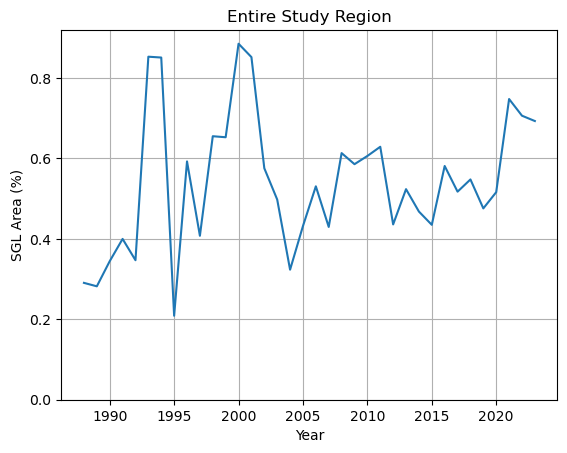

In [121]:
# plot the annual timeseries of the entire region
df_to_use = df_all

subset = df_to_use[c_1yr] 
subset = subset.T

total_area = np.nansum(df_to_use['area_dc'])

areas = []
ys = np.arange(1988,2024)
for y in ys:
    areas.append(np.nansum(df_to_use[f'water_{y}_m2'])/(1000*1000))

fig,axs = plt.subplots()

axs.plot( ys, areas/total_area *100, label=c )


axs.grid(zorder=1)
axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (%)")
axs.set_title("Entire Study Region")
axs.set_ylim(0,)

Text(0.5, 1.0, '1-year intervals')

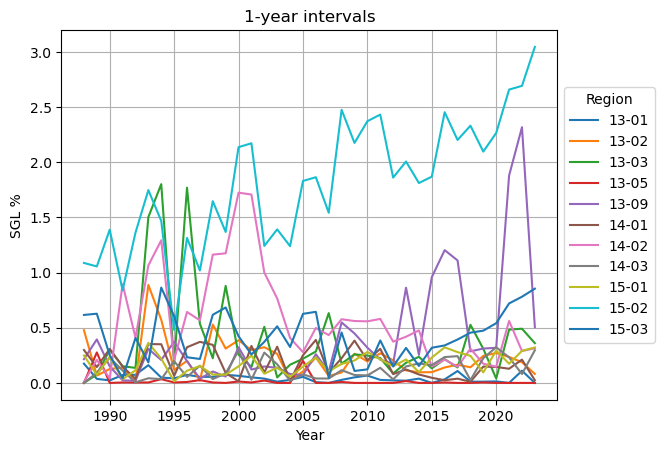

In [122]:
# plot the annual timeseries of each o2region
# for each o2_region, lets calculate the total water area each year/interval
df_to_use = df_all
df_o2 = df_to_use.groupby("o2_region").sum(numeric_only=True)

subset = df_o2[c_1yr] 
subset = subset.T

fig,axs = plt.subplots()

for c in subset.columns:
# for c in ['14-01','14-02','14-03']:
    # grab debris-covered area (in m2)
    dc_area = df_o2.loc[c]['area_dc']*1000*1000
    axs.plot( np.arange(1988,2024), subset[c].values / (dc_area) * 100, label=c )
axs.legend(loc='center left', title='Region', bbox_to_anchor=(1,0.5))

axs.grid(zorder=1)
axs.set_xlabel("Year")
axs.set_ylabel("SGL %")
axs.set_title("1-year intervals")

Text(0.5, 1.0, '1-year intervals')

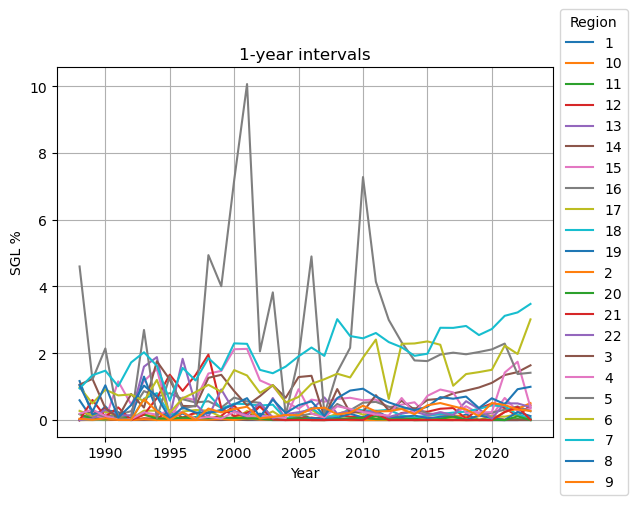

In [123]:
# plot the annual timeseries of each o3region
# for each o2_region, lets calculate the total water area each year/interval
df_to_use = df_all
df_o2 = df_to_use.groupby("o3_region").sum(numeric_only=True)

subset = df_o2[c_1yr] 
subset = subset.T

fig,axs = plt.subplots()

for c in subset.columns:
# for c in ['14-01','14-02','14-03']:
    # grab debris-covered area (in m2)
    dc_area = df_o2.loc[c]['area_dc']*1000*1000
    axs.plot( np.arange(1988,2024), subset[c].values / (dc_area) * 100, label=c )
axs.legend(loc='center left', title='Region', bbox_to_anchor=(1,0.5))

axs.grid(zorder=1)
axs.set_xlabel("Year")
axs.set_ylabel("SGL %")
axs.set_title("1-year intervals")

Text(0.5, 1.0, '5-year(ish) intervals')

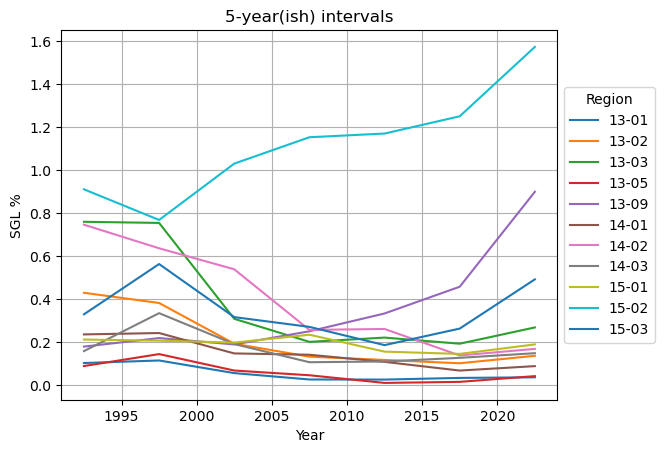

In [93]:
# # plot the 5-year timeseries of each o2region
# # for each o2_region, lets calculate the total water area each year/interval
# df_o2 = df_all.groupby("o2_region").sum(numeric_only=True)

# subset = df_o2[c_5yr]
# subset = subset.T

# fig,axs = plt.subplots()

# for c in subset.columns:
# # for c in ['14-01','14-02','14-03']:
#     dc_area = df_o2.loc[c]['area_dc']*1000*1000
#     axs.plot( np.arange(1992.5,2024,5), subset[c].values/dc_area * 100, label=c )
# axs.legend(loc='center left', title='Region', bbox_to_anchor=(1,0.5))

# axs.grid(zorder=1)
# axs.set_xlabel("Year")
# axs.set_ylabel("SGL %")
# axs.set_title("5-year(ish) intervals")

Text(0.5, 1.0, '5-year(ish) intervals')

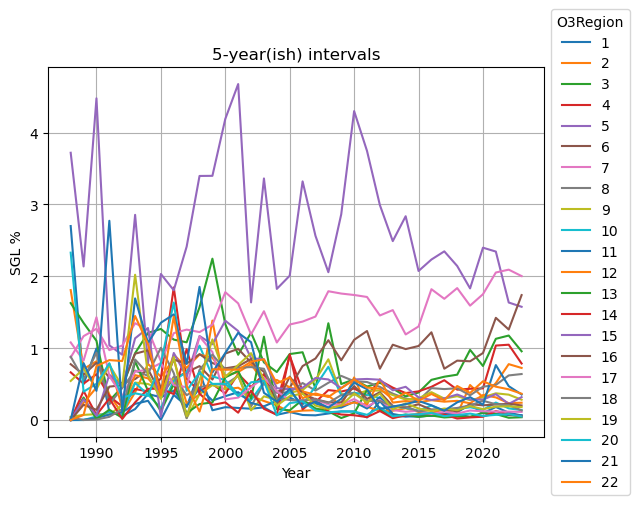

In [25]:
# # plot the annual timeseries of each o3region
# df_o3 = df_all.groupby("o3_region").sum(numeric_only=True)

# subset = df_o3[c_1yr]
# subset = subset.T

# fig,axs = plt.subplots()

# for c in np.arange(1,23):
# # for c in ['9']:
#     c = str(c)
#     dc_area = df_o3.loc[c]['area_dc']*1000*1000
#     axs.plot( np.arange(1988,2024), subset[c].values/dc_area * 100, label=c)

# axs.legend(loc='center left', title='O3Region', bbox_to_anchor=(1,0.5))

# axs.grid(zorder=1)
# axs.set_xlabel("Year")
# axs.set_ylabel("SGL %")
# axs.set_title("5-year(ish) intervals")

In [124]:
# id outliers if they are x-times the median absolute distance to median
def id_outliers(array, x): 
    med_d = np.abs(array - np.nanmedian(array)) # distance from median for each obs
    mdev = np.nanmedian(med_d) # median of those distances
    
    if mdev!=0:
        mask = med_d/mdev < x
    else:
        mask = [True for i in array]
    return mask

Text(0.5, 1.0, 'Name: Baltoro Glacier\nRGI_ID: RGI2000-v7.0-G-14-11612')

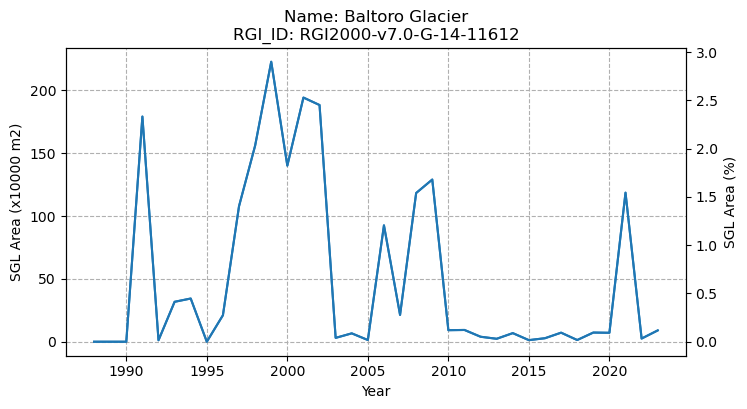

In [125]:
# plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
rgi_id = 'RGI2000-v7.0-G-14-33456' # choose which you want to provide
glacier_name = 'Baltoro'

# get the rgi_id if glacier name was provided
if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]
g_df = df_all[df_all['rgi_id']==rgi_id]
glacier_name = rgi_gdf[rgi_gdf['rgi_id']==rgi_id]['glac_name'].values[0]

# formatting of data
ys = np.arange(1988,2024)
areas = g_df[c_1yr].values[0]/10000
mask = id_outliers(areas, 99999)
dc_area = g_df['area_dc'].values[0]#*(1000*1000)/10000 /100

# initiate figure
fig,axs = plt.subplots(figsize=(8,4))
ax2 = axs.twinx() # twin axis for showing percentage

# plot the data
axs.plot( ys[mask], areas[mask])
ax2.plot(ys[mask], areas[mask]/dc_area)

axs.grid(zorder=1, linestyle='dashed')
axs.set_xlabel("Year")
axs.set_ylabel("SGL Area (x10000 m2)")
ax2.set_ylabel("SGL Area (%)")

axs.set_title(f"Name: {glacier_name}\nRGI_ID: {rgi_id}")

In [79]:
g_df

,rgi_id,o1_region,o2_region,water_1988_m2,water_1989_m2,water_1990_m2,water_1991_m2,water_1992_m2,water_1993_m2,water_1994_m2,...,water_2023_m2,water_1990_1994_m2,water_1995_1999_m2,water_2000_2004_m2,water_2005_2009_m2,water_2010_2014_m2,water_2015_2019_m2,water_2020_2023_m2,o3_region,area_dc
465,RGI2000-v7.0-G-15-00467,15,15-01,NaN,0.0,1755.0,2254.0,17731.0,67202.0,57361.0,...,26504.0,39690.0,19001.0,10227.0,11742.0,8333.0,10191.0,16754.0,10,19.151177


In [85]:
str(np.nan)

'nan'